In [1]:
import pandas as pd
import os
os.chdir("/media/careyjohn/DATA/kepler_ptf_research/k2_c4/python_Kepler_data_k2c4/results")
column_names = ['EPIC','Period','']  

df = pd.DataFrame([ ], columns = column_names)
df.to_csv('K2_M_C1_epic_period.csv', index=False)

In [2]:
def append_csv(x1, x2):

    df = pd.read_csv('K2_M_C1_epic_period.csv')
    column_names = ['EPIC','Period']  
    
    if x1 not in list(df['EPIC'])  :
    
    
        df2 = pd.DataFrame([[x1, x2]], columns = column_names)

        df_add = df.append(df2)

        df_add.to_csv('K2_M_C1_epic_period.csv', index = False)
    #else:
        #print x3,'already exists'

In [1]:
from matplotlib import pyplot as plt
import pyfits, os, sys, matplotlib, pylab
import numpy as np
from gatspy import periodic
import pandas as pd

#os.chdir("C:\\Users\\CareyJohn\\kplr_data_test")  #change directory
#os.chdir("/media/careyjohn/OS/Users/CareyJohn/Desktop/PSROC_klpr/K2_LLC_FITS/k2_camp1/ktwo201323410_C1")

def k2_llc_analysis(epic):
    
    os.chdir("D:/kepler_ptf_research/k2_c1/python_Kepler_data_k2c1/results/")
    
    df =  pd.read_csv('K2_M_C1_epic_period.csv')
    
    if epic not in list(df['EPIC']):
    
        ID = "ktwo"+str(epic)

        #os.chdir("C:/Users/CareyJohn/Desktop/PSROC_klpr/K2_LLC_FITS/k2_camp1/"+ID+"_C1")
        #os.chdir("D:/kepler_ptf_research/k2_c1/python_Kepler_data_k2c1"+ID+"_C1")
        
        #os.chdir("D:/kepler_ptf_research/k2_c4/python_Kepler_data_k2c4")
        os.chdir("/media/careyjohn/DATA/kepler_ptf_research/k2_c4/python_Kepler_data_k2c4")
        #nowpath = os.getcwd()
        #print (nowpath)

        data = pyfits.open(ID+"-c04_llc.fits")  #open the kepler fits data
        print (data.info())

        time = data[1].data.field('TIME')
        sap_flux=data[1].data.field('SAP_FLUX')
        sap_flux_err=data[1].data.field('SAP_FLUX_ERR')
        pdcsap_flux=data[1].data.field('PDCSAP_FLUX')
        pdcsap_flux_err=data[1].data.field('PDCSAP_FLUX_ERR')


        #plt.plot(time,pdcsap_flux)
        #plt.show()

        lc=zip(time,sap_flux,sap_flux_err,pdcsap_flux,pdcsap_flux_err)  #zip the open data 

        #print(list(lc))
        #os.chdir("..")
        #os.chdir("D:/kepler_ptf_research/k2_c1/python_Kepler_data_k2c4/results/")
        os.chdir("/media/careyjohn/DATA/kepler_ptf_research/k2_c4/python_Kepler_data_k2c4/results")
        if not os.path.exists("ktwo"+str(epic)+"_C4"):
            os.mkdir("ktwo"+str(epic)+"_C4")
        
        #os.chdir("D:/kepler_ptf_research/k2_c1/python_Kepler_data_k2c4/results/ktwo"+str(epic)+"_C1")
        os.chdir("/media/careyjohn/DATA/kepler_ptf_research/k2_c4/python_Kepler_data_k2c4/results/ktwo"+str(epic)+"_C4")
        if not os.path.exists(ID+"-c04_llc.fits.lc"):

            output_file = ID+"-c04_llc.fits.lc"  #write the zip of the open data in a text book
            out = open(output_file,'w')
            for i in lc:
                write = '%s %s %s %s %s' %(i[0],i[1],i[2],i[3],i[4])
                out.write(write+'\n')
            out.close()

        filej = open( ID+"-c04_llc.fits.lc")

        datar = np.loadtxt( filej, dtype={'names':('time', '2', '3', 'flux', 'err'), 'formats':('f4','f4','f4','f4','f4')})



        masknan = -np.isnan(datar['flux']) # 遮閉掉nan的值, 加上'-'號是為了讓nan=false;數值=true
        masknan_err = -np.isnan(datar['err'])

        #print(data['flux'])
        #print(np.isnan(data['flux']))
        #print(masknan)
        #print(data['flux'][masknan])

        time = datar['time'][masknan]
        flux = datar['flux'][masknan]/np.mean(datar['flux'][masknan])  # 之後會被動手腳
        flux_raw = datar['flux'][masknan]/np.mean(datar['flux'][masknan])# 為了上一個而留下的替代品
        err = datar['err'][masknan_err]/np.mean(datar['err'][masknan])
        #print(time)
        #print(flux)
        #print(flux_raw)

        fluxC = np.zeros(len(flux))
        errC = np.zeros(len(err))

        separationtime=[]
        separationtime.append(0)

        for i in range(len(time)-1):
            if time[i+1]-time[i] > 3*(time[2]-time[1]):
                separationtime.append(i)
        separationtime.append(len(time))
        binsize = 10
        for k in range(len(separationtime)-1):
            #print(k)
            #take 10 points mean and replace it 
            for i in range(separationtime[k],separationtime[k+1]):

                if i >= (separationtime[k]+binsize) and i <= (separationtime[k+1]-binsize):
                    fluxC[i] = np.median(flux[i-binsize:i+binsize])
                    errC[i] = np.median(flux[i-binsize:i+binsize])
                else:
                    fluxC[i] = flux[i]
                    errC[i] = err[i]
            #plt.plot(time,flux_raw)
            #plt.scatter(time,flux_raw)
            #plt.plot(time,fluxC)
            #plt.scatter(time,fluxC)
            #plt.show()
            #plt.clf()
            #print (fluxC)
            #print (flux_raw)

            #obseverd subtract calculate
            fluxdiff = flux - fluxC

            #remove the peak value which > 1 sigam
            maskpeak = fluxdiff > 1.0*fluxdiff.std()

            for n,i in enumerate(maskpeak):
                if i:
                    if n >= (separationtime[k]+binsize) and n <= (separationtime[k+1]-binsize):
                        flux[n] = np.median(flux[n-binsize:n+binsize])
                    else:
                        flux[n] = flux[n]
        plt.plot(time,flux_raw, 'r')
        plt.plot(time,flux_raw, '.')
        plt.scatter(time,flux_raw)
        plt.plot(time,fluxC)
        plt.scatter(time,fluxC)
        plt.xlabel('Time(BJD - 2454833)')
        plt.ylabel('Normalized flux')
        plt.xlim(1976,1980)
        plt.show()
        plt.clf()
        print (fluxC)
        print (flux_raw)

        model = periodic.LombScargle(fit_period = True)

        model.optimizer.period_range = ( 0.1, 79.0)

        model.fit(time, flux);

        model.best_period

        P = model.best_period

        print(epic, P)
        
        os.chdir("/media/careyjohn/DATA/kepler_ptf_research/k2_c4/python_Kepler_data_k2c4/results")
        
        #if P > 79.0:   #這裡LSP的週期測試上限為79.0 days，若分析時超過79.0，則代表分析資料或過程有問題，不能寫入csv檔並儲存
        #    append_csv(epic, 0)  
        #else:
        #    append_csv(epic, P)
            
        #os.chdir("D:/kepler_ptf_research/k2_c1/python_Kepler_data_k2c1")

In [3]:
k2_llc_analysis(201631069)

Filename: ktwo201917390-c01_llc.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU      54   ()              
1    LIGHTCURVE  BinTableHDU    155   4022R x 20C   [D, E, J, E, E, E, E, E, E, J, D, E, D, E, D, E, D, E, E, E]   
2    APERTURE    ImageHDU        48   (18, 18)     int32   


C:\Users\CareyJohn\Anaconda3\lib\site-packages\pyfits\util.py:893: UserWarning: Could not find appropriate MS Visual C Runtime library or library is corrupt/misconfigured; cannot determine whether your file object was opened in append mode.  Please consider using a file object opened in write mode instead.
  'Could not find appropriate MS Visual C Runtime '


None


C:\Users\CareyJohn\Anaconda3\lib\site-packages\ipykernel\__main__.py:56: DeprecationWarning: numpy boolean negative, the `-` operator, is deprecated, use the `~` operator or the logical_not function instead.
C:\Users\CareyJohn\Anaconda3\lib\site-packages\ipykernel\__main__.py:57: DeprecationWarning: numpy boolean negative, the `-` operator, is deprecated, use the `~` operator or the logical_not function instead.


Finding optimal frequency:
 - Estimated peak width = 0.0785
 - Using 5 steps per peak; omega_step = 0.0157
 - User-specified period range:  0.1 to 80
 - Computing periods at 4000 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
0.707796710433


In [8]:
#data_list = [201842163, 201909533, 201917390]
#for i in range(len(data_list)):
#    k2_llc_analysis(data_list[i])

In [17]:
os.getcwd()

'D:\\kepler_ptf_research\\k2_c1'

In [18]:
dfs = pd.read_csv('ptf_ha_positive_sub_k2c1.csv')

In [20]:
len(dfs['EPIC'])

1970

In [21]:
os.chdir("D:/kepler_ptf_research/k2_c1/python_Kepler_data_k2c1")

In [ ]:
for i in range(len(dfs['EPIC'])):
    k2_llc_analysis(int(dfs['EPIC'][i]))

Filename: ktwo201136343-c01_llc.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU      54   ()              
1    LIGHTCURVE  BinTableHDU    155   4022R x 20C   [D, E, J, E, E, E, E, E, E, J, D, E, D, E, D, E, D, E, E, E]   
2    APERTURE    ImageHDU        48   (15, 14)     int32   


C:\Users\CareyJohn\Anaconda3\lib\site-packages\pyfits\util.py:893: UserWarning: Could not find appropriate MS Visual C Runtime library or library is corrupt/misconfigured; cannot determine whether your file object was opened in append mode.  Please consider using a file object opened in write mode instead.
  'Could not find appropriate MS Visual C Runtime '
C:\Users\CareyJohn\Anaconda3\lib\site-packages\ipykernel\__main__.py:65: DeprecationWarning: numpy boolean negative, the `-` operator, is deprecated, use the `~` operator or the logical_not function instead.
C:\Users\CareyJohn\Anaconda3\lib\site-packages\ipykernel\__main__.py:66: DeprecationWarning: numpy boolean negative, the `-` operator, is deprecated, use the `~` operator or the logical_not function instead.


None
Finding optimal frequency:
 - Estimated peak width = 0.0785
 - Using 5 steps per peak; omega_step = 0.0157
 - User-specified period range:  0.1 to 70
 - Computing periods at 3995 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
201136343 0.796080272781
Filename: ktwo201134862-c01_llc.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU      54   ()              
1    LIGHTCURVE  BinTableHDU    155   4022R x 20C   [D, E, J, E, E, E, E, E, E, J, D, E, D, E, D, E, D, E, E, E]   
2    APERTURE    ImageHDU        48   (15, 14)     int32   
None
Finding optimal frequency:
 - Estimated peak width = 0.0785
 - Using 5 steps per peak; omega_step = 0.0157
 - User-specified period range:  0.1 to 70
 - Computing periods at 3999 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
201134862 84.8321897182
Filename: ktwo201140566-c01_llc.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY   

In [11]:
def k2_llc_lightcurve(epic):
        ID = "ktwo"+str(epic)
        os.chdir("D:/kepler_ptf_research/k2_c1/python_Kepler_data_k2c1/results/ktwo"+str(epic)+"_C1")
        filej = open( ID+"-c01_llc.fits.lc")

        datar = np.loadtxt( filej, dtype={'names':('time', '2', '3', 'flux', 'err'), 'formats':('f4','f4','f4','f4','f4')})



        masknan = -np.isnan(datar['flux']) # 遮閉掉nan的值, 加上'-'號是為了讓nan=false;數值=true
        masknan_err = -np.isnan(datar['err'])

        #print(data['flux'])
        #print(np.isnan(data['flux']))
        #print(masknan)
        #print(data['flux'][masknan])

        time = datar['time'][masknan]
        flux = datar['flux'][masknan]/np.mean(datar['flux'][masknan])  # 之後會被動手腳
        flux_raw = datar['flux'][masknan]/np.mean(datar['flux'][masknan])# 為了上一個而留下的替代品
        err = datar['err'][masknan_err]/np.mean(datar['err'][masknan])
        #print(time)
        #print(flux)
        #print(flux_raw)

        fluxC = np.zeros(len(flux))
        errC = np.zeros(len(err))

        separationtime=[]
        separationtime.append(0)

        for i in range(len(time)-1):
            if time[i+1]-time[i] > 3*(time[2]-time[1]):
                separationtime.append(i)
        separationtime.append(len(time))
        binsize = 10
        for k in range(len(separationtime)-1):
            #print(k)
            #take 10 points mean and replace it 
            for i in range(separationtime[k],separationtime[k+1]):

                if i >= (separationtime[k]+binsize) and i <= (separationtime[k+1]-binsize):
                    fluxC[i] = np.median(flux[i-binsize:i+binsize])
                    errC[i] = np.median(flux[i-binsize:i+binsize])
                else:
                    fluxC[i] = flux[i]
                    errC[i] = err[i]
            #plt.plot(time,flux_raw)
            #plt.scatter(time,flux_raw)
            #plt.plot(time,fluxC)
            #plt.scatter(time,fluxC)
            #plt.show()
            #plt.clf()
            #print (fluxC)
            #print (flux_raw)

            #obseverd subtract calculate
            fluxdiff = flux - fluxC

            #remove the peak value which > 1 sigam
            maskpeak = fluxdiff > 1.0*fluxdiff.std()

            for n,i in enumerate(maskpeak):
                if i:
                    if n >= (separationtime[k]+binsize) and n <= (separationtime[k+1]-binsize):
                        flux[n] = np.median(flux[n-binsize:n+binsize])
                    else:
                        flux[n] = flux[n]
        plt.plot(time,flux_raw, 'r')
        plt.plot(time,flux_raw, '.')
        plt.scatter(time,flux_raw)
        plt.plot(time,fluxC)
        plt.scatter(time,fluxC)
        plt.xlabel('Time(BJD - 2454833)')
        plt.ylabel('Normalized flux')
        #plt.xlim(1976,1980)
        plt.show()
        plt.clf()

C:\Users\CareyJohn\Anaconda3\lib\site-packages\ipykernel\__main__.py:10: DeprecationWarning: numpy boolean negative, the `-` operator, is deprecated, use the `~` operator or the logical_not function instead.
C:\Users\CareyJohn\Anaconda3\lib\site-packages\ipykernel\__main__.py:11: DeprecationWarning: numpy boolean negative, the `-` operator, is deprecated, use the `~` operator or the logical_not function instead.


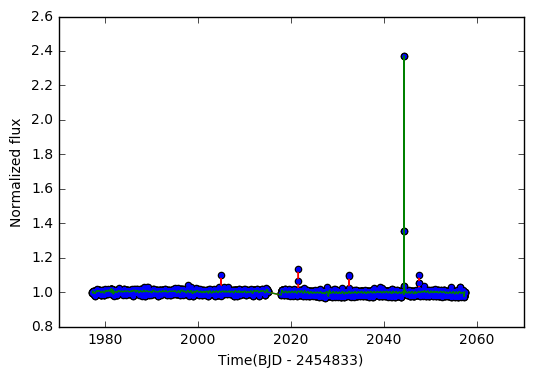

In [22]:
k2_llc_lightcurve(201560437)